In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors
import matplotlib.cm as colormap
from scipy.signal import savgol_filter

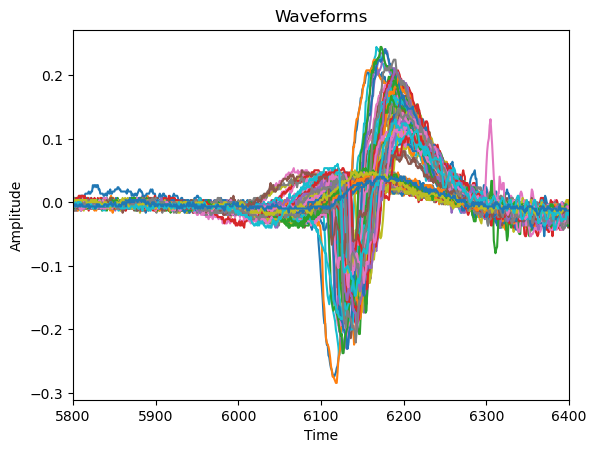

In [4]:
filepath = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/MPhys Sem 1 SiPM-Scintillation (KeySight Oscilloscope)/"
filename = "55V_1200V_Ar_filter.csv"
seg_len = 12500
data = np.genfromtxt(filepath + filename, delimiter=',', skip_header=3)
n_segs = len(data) // seg_len

waveforms = np.zeros((n_segs, seg_len, 3))
for i in range(n_segs):
    waveforms[i] = data[i*seg_len:(i+1)*seg_len]

for waveform in waveforms:
    plt.plot(waveform[:, 2])

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveforms")
plt.xlim(5800,6400)
plt.show()

In [20]:
def plot1d(h, bins, ax=None, **plot_kwargs):
    '''
    Plots already binned data in a histogram
    Provide explicit axes to choose where to plot it, otherwise the current axes will be used'''
    if ax==None:
        ax = plt.gca() # get current axes
    # creating a list of the bin centers
    binw = bins[1]-bins[0] # assuming equal spaced bins
    binc = [ b + binw/2 for b in bins[:-1]]

    ax.bar(binc, h, width=binw, **plot_kwargs)
    return ax

def get_bin_centres(bins_edges, dtype='list'):
    binw = bins_edges[1]-bins_edges[0] # assuming equal spaced bins
    binc = [ b + binw/2 for b in bins_edges[:-1]]
    if dtype == 'ndarray':
        binc = np.array(binc)

def determine_roi(all_waveforms, plot=False):
    """Determine the Region of Interest (ROI).  Locate the common peak in all waveforms 
    and the beginning of integration region.  An end value for the ROI is provided but is later 
    discarded.

    Parameters
    ----------
    all_waveforms : list of 2d np arrays
        list with each entry being a 2d np array describing a waveform with columns (time, amplitude)
    plot : bool, optional
        plot the determined roi or not, by default False

    Returns
    -------
    int, int, int
        indices of begin of ROI, end of ROI, location of peak
    """
    time = []
    amplitude = []
    bins = len(all_waveforms[0])
    
    print("Determining ROI...")
    for index, waveform in tqdm(enumerate(all_waveforms)):
        for index_inner, single_point in enumerate(waveform):
            time.append(single_point[0])
            amplitude.append(single_point[1])
    
    smallest = np.min(amplitude)
    amplitude = amplitude + np.abs(smallest)

    time = np.array(time)
    time *= 10**9

    hist, edges = np.histogram(time, bins, weights=amplitude)
    plot1d(hist, edges, alpha= 0.2, label='raw signal')
    hist_filtered = savgol_filter(hist, 60, 9)
    hist_deriv = savgol_filter(hist, 60, 9, 1, edges[1] - edges[0])
    visual_extrema = np.where(np.abs(hist_deriv) <= np.max(hist_deriv)/30, hist_filtered, np.full(np.shape(hist), np.nan))
    plot1d(hist_filtered, edges, alpha = 0.2, color='r', label='smoothed signal')
    #plt.scatter(get_bin_centres(edges), visual_extrema,  color='r')
    
    numerical_extrema = np.where(np.isnan(visual_extrema) , np.zeros(np.shape(visual_extrema)), visual_extrema)
    
    max_loc = np.argmax(numerical_extrema)
    plt.scatter(get_bin_centres(edges)[max_loc], visual_extrema[max_loc], color='r')
    #print(visual_extrema[max_loc])

    #define some dummy variables to find the peak before 
    iterator = max_loc
    activate = False
    roi_begin = 0

    while iterator >= 0:

        if(numerical_extrema[iterator] == 0):
            activate = True
        
        else:
            if activate == True:
                roi_begin = iterator
                break


        iterator -= 1


    plt.scatter(get_bin_centres(edges)[roi_begin], visual_extrema[roi_begin], color='r')

    #For the upper ROI limit just take 3 times the 
    diff = max_loc - roi_begin
    roi_end = max_loc + 1 * diff
    

    #plt.scatter(get_bin_centres(edges)[roi_end], hist_filtered[roi_end], color='r')
    plt.xlabel("time[ns]", fontsize = 18)
    plt.ylabel("Summed signal[V]", fontsize = 18)
    #plt.title("ROI determination")
    plt.legend(fontsize=18)
    plt.tick_params(axis='both', labelsize=16)
    plt.tight_layout()
    

    if plot==True:
        #plt.savefig("PLOTS_FOLDER + ROI_example_sipm.png", dpi=600)
        plt.show()
    plt.cla()
    print("ROI determined to be [{0}:{1}]".format(roi_begin, roi_end))

    return roi_begin, roi_end, max_loc

Determining ROI...


101it [00:00, 120.91it/s]


TypeError: 'NoneType' object is not subscriptable

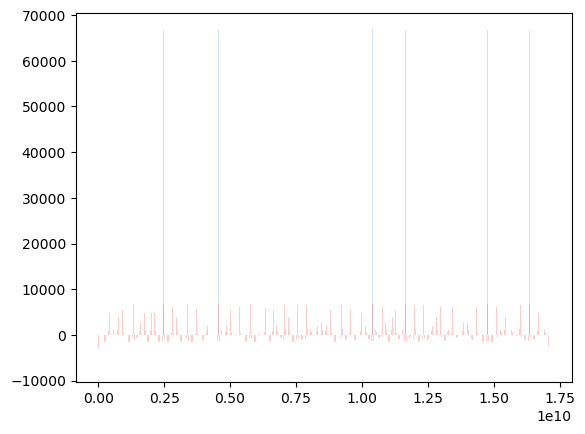

In [23]:
determine_roi(waveforms)

In [ ]:
trig_pos = np.zeros(n_segs)
for i in range(n_segs):
    trig_pos[i] = np.argmin(waveforms[i, :, 1])

peak_pos = np.zeros(n_segs)
for i in range(n_segs):
    peak_pos[i] = np.argmax(waveforms[i, :, 2])

print(peak_pos-trig_pos)

[ 40.  42.  41.  37.  41.  67.  48.  73.  63.  39.  40.  60.  68.  36.
  40.  41.  56.  37.  60.  62.  34.  38.  24.  50.  38.  48.  42.  63.
  38.  32.  57.  35.  41.  63.  58.  35.  35.  59.  44.  28.  61. 648.
  40.  36.  31.  35.  66.  34.  42.  49.  40.  57.  40.  38.  32.  43.
  40.  75.  55.  48.  52.  64.  75.  99.  69.  72.  68.  58.  51.  43.
  37.  41.  38.  38.  40.  43. 149.  51.  68.  43.  72.  59.  41.  40.
  41.  52.  51.  42.  38.  52.  39.  78.  39.  49.  48.  63.  38.  40.
  28.  38.  44.]


In [7]:
areas = np.zeros(n_segs)

area = np.zeros(500)
for i in range(n_segs):
    for j in range(500):
        pos = int(peak_pos[i]-trig_pos[i]+j)
        area[j] = (waveforms[i,pos+1,0]-waveforms[i, pos, 0])*np.sum(waveforms[i, pos:pos+1, 2])/2
        if area[j] < 0: area[j] = 0
    areas[i] = np.sum(area)

1.4581369221999277e-11


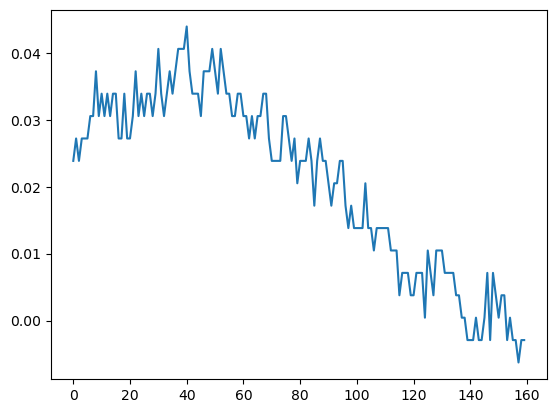

3.225912898282694e-11


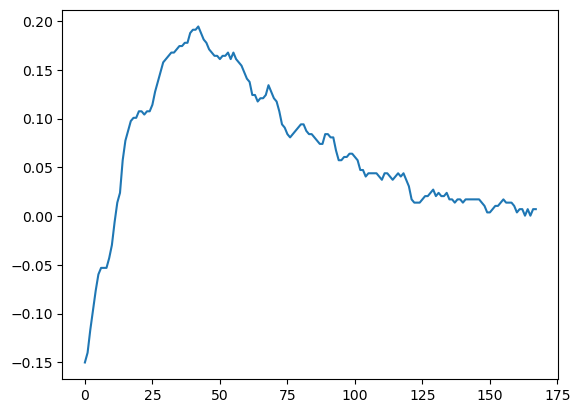

1.6296824417422072e-11


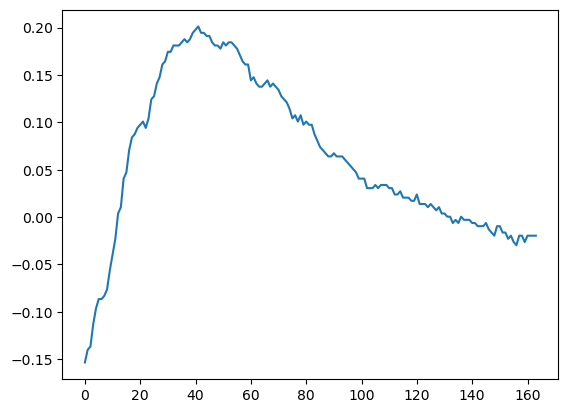

1.3723641602776481e-11


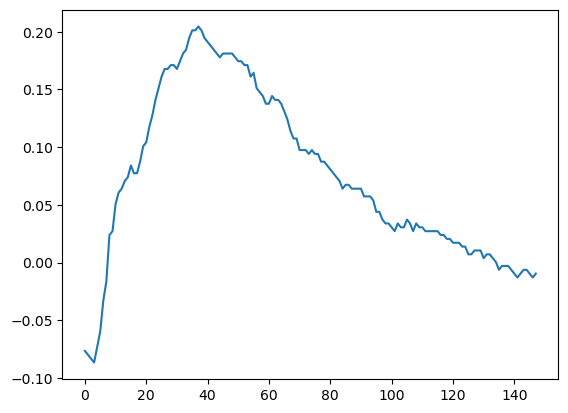

4.581551062988473e-11


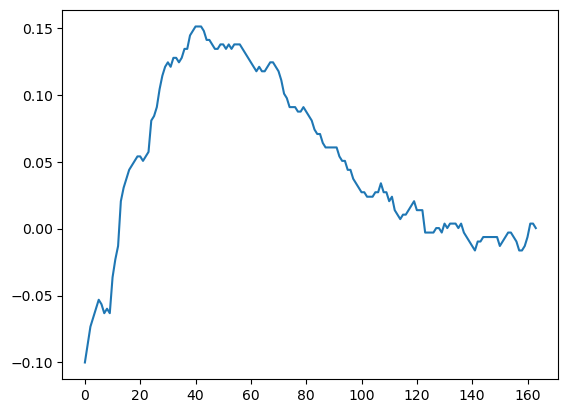

2.299138529570507e-11


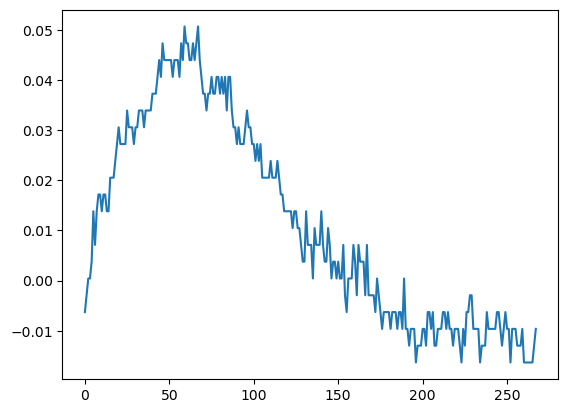

2.299138511989368e-11


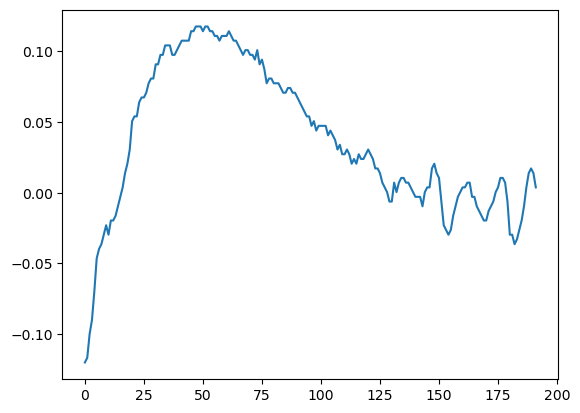

1.2008186411679421e-11


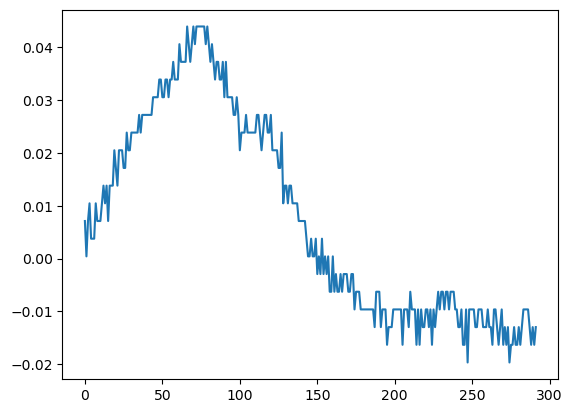

4.4957783333181215e-11


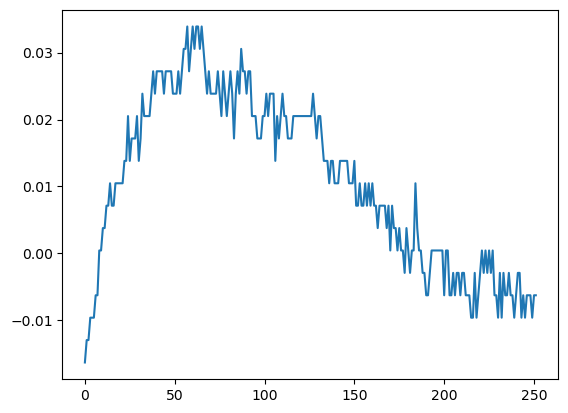

2.4706840686613523e-11


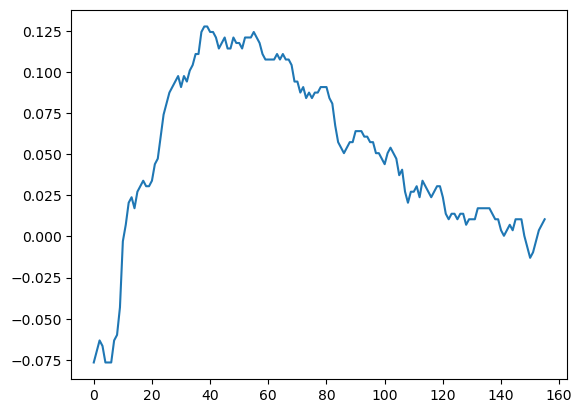

2.3849112608408593e-11


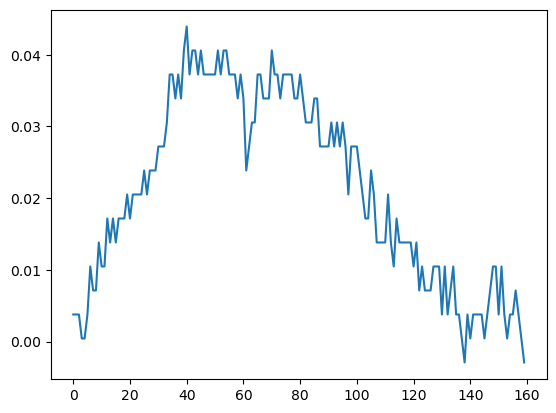

4.340958754289061e-11


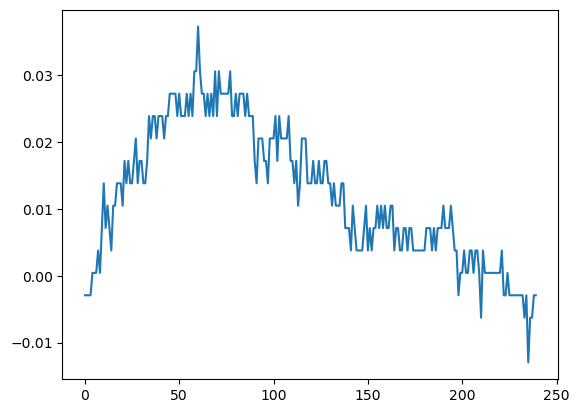

1.286591422148846e-11


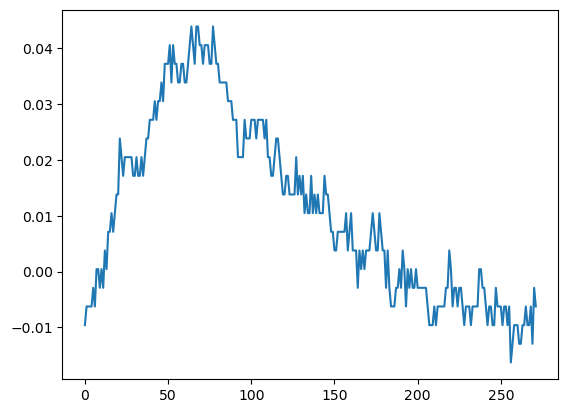

2.213365734769809e-11


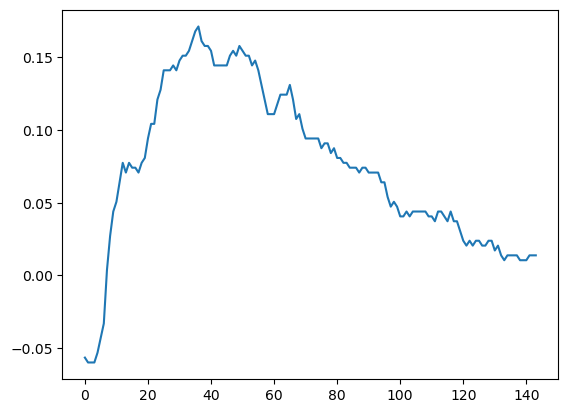

1.4414109062794937e-11


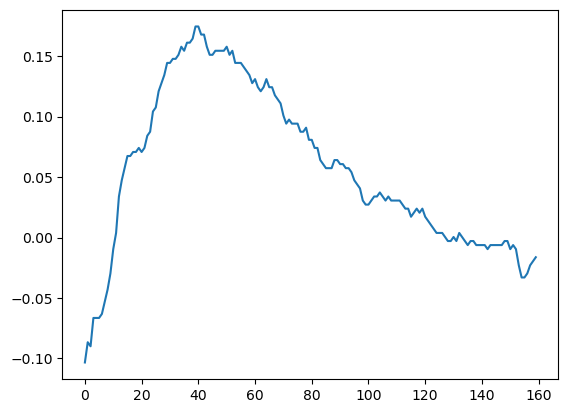

4.838869303974321e-11


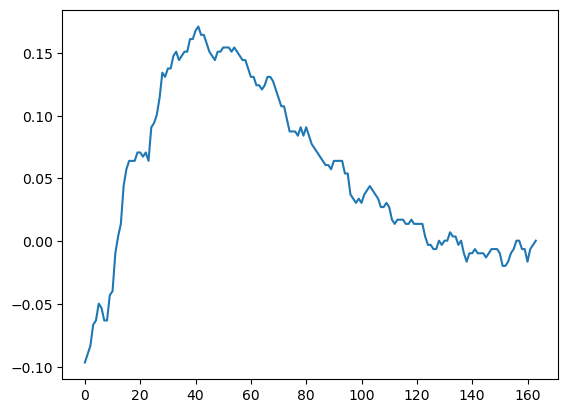

2.899547946469325e-11


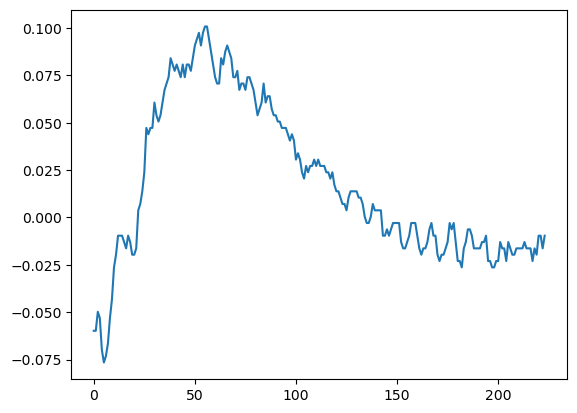

1.286591422748846e-11


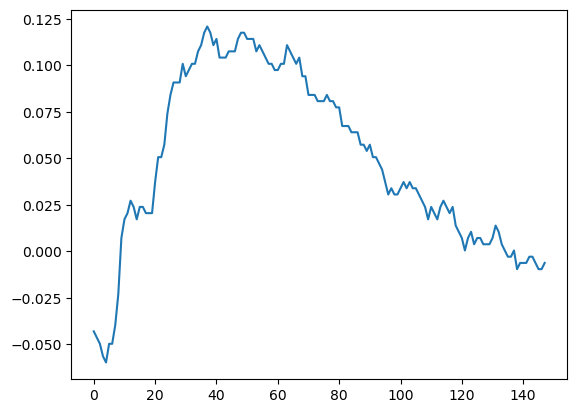

5.7656437101652196e-11


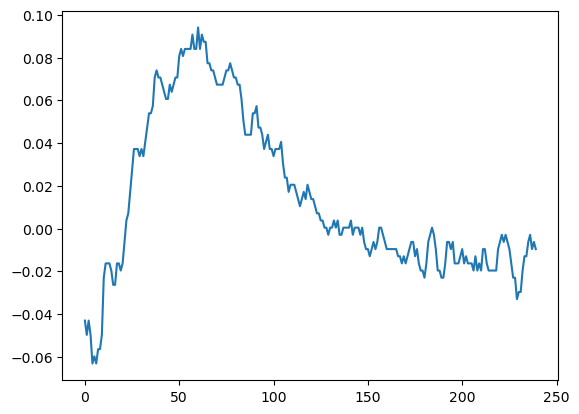

3.3284117069721605e-11


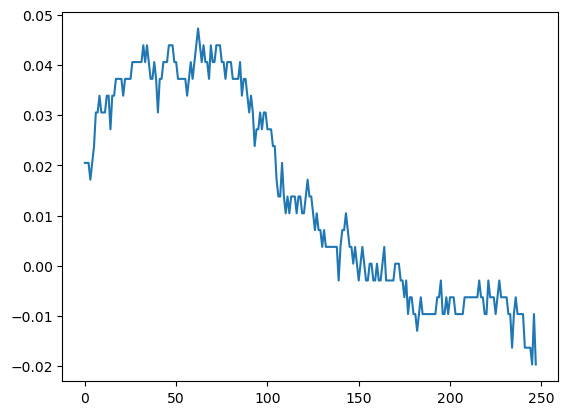

2.470684046783108e-11


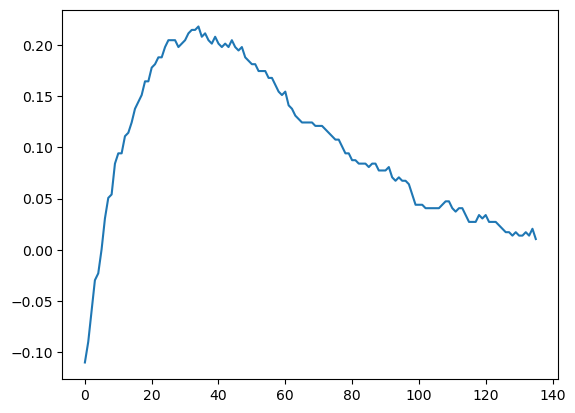

2.5564567948345993e-11


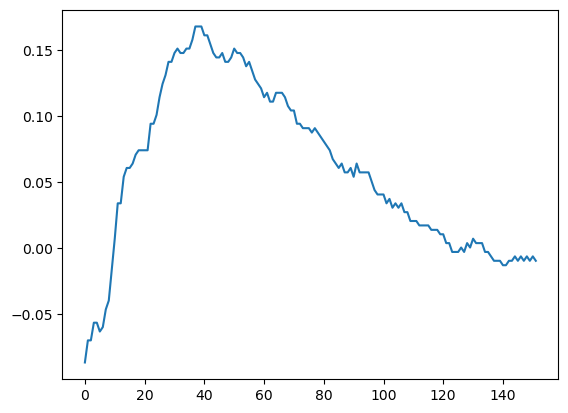

1.2008186270839081e-11


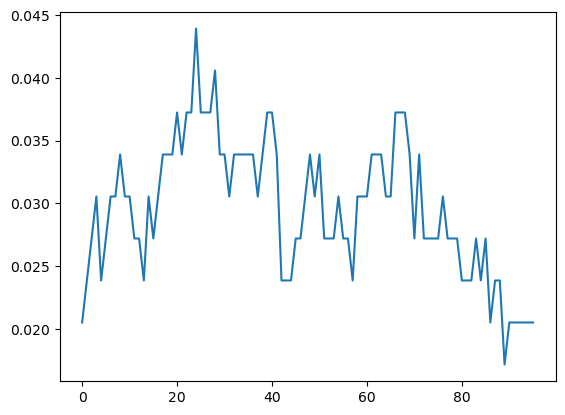

1.6296824716909475e-11


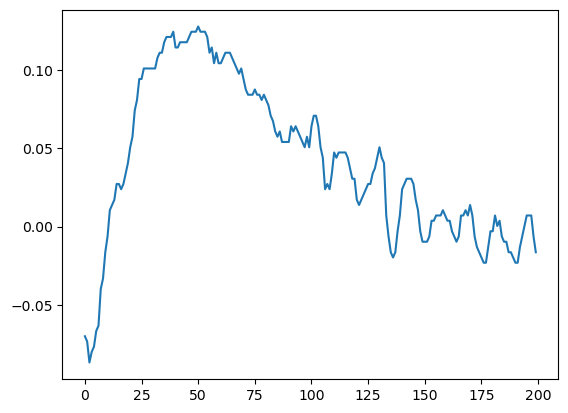

3.2593649836726516e-11


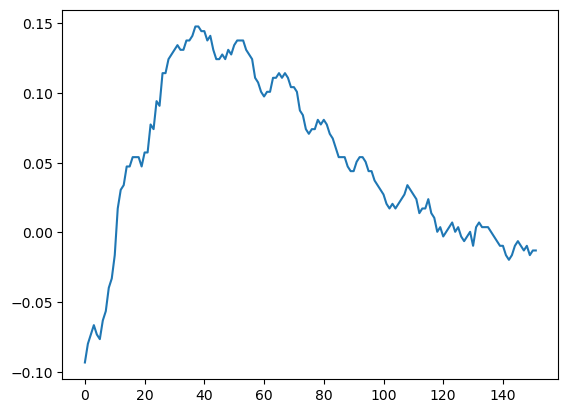

3.156866125964974e-11


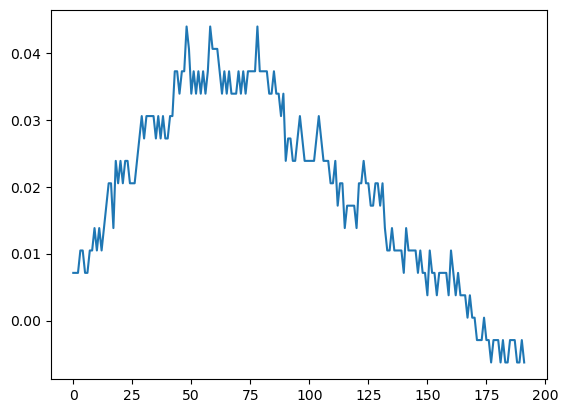

3.740549484927687e-11


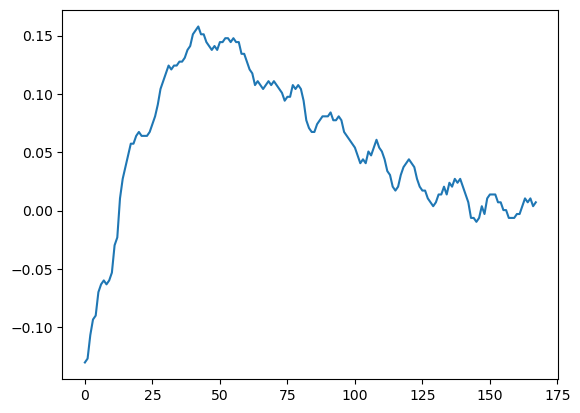

2.3849112581839012e-11


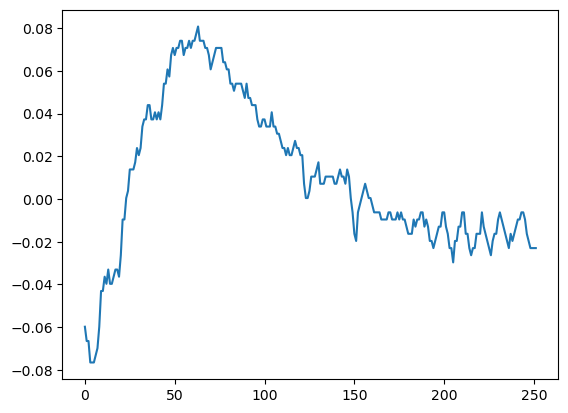

1.3723641799230267e-11


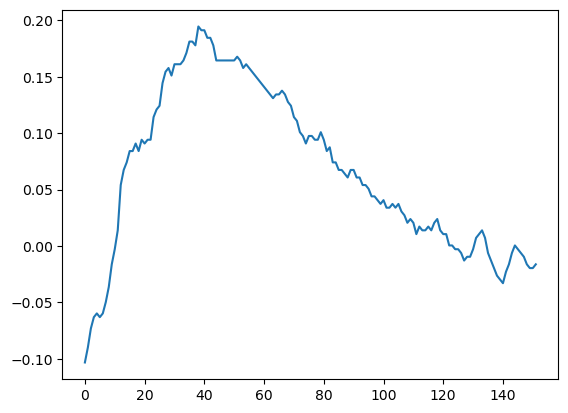

2.6422297122375403e-11


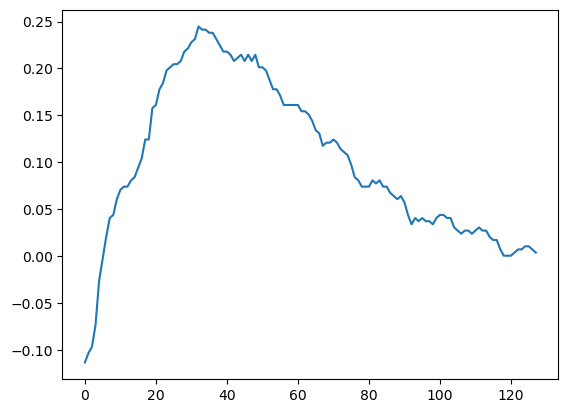

2.230091795355591e-11


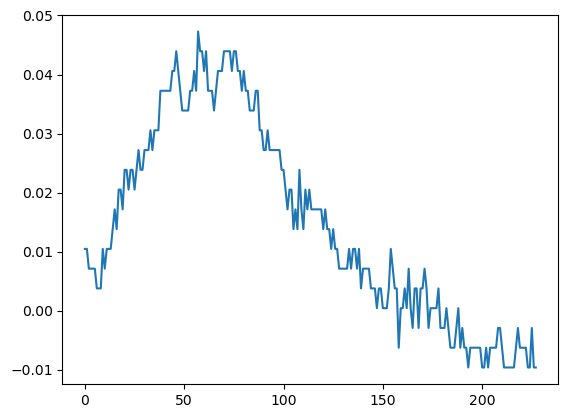

1.5439096768260094e-11


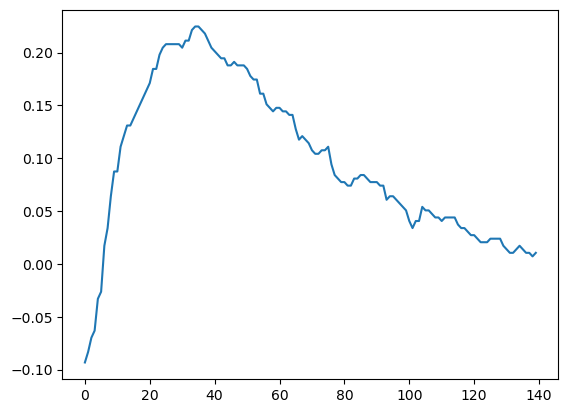

1.458136928774518e-11


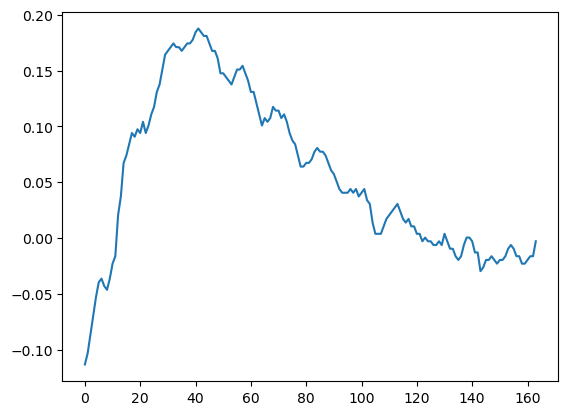

1.3723641799230267e-11


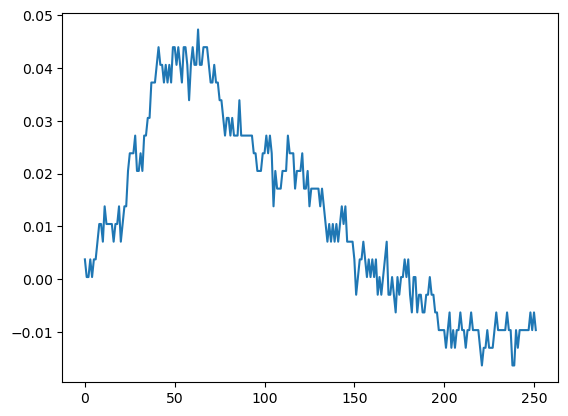

4.5125044825124925e-11


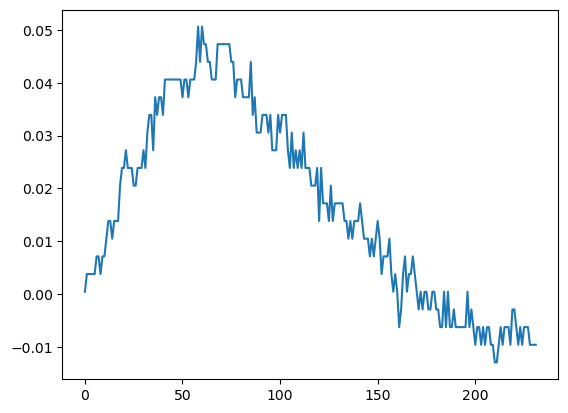

3.9978678967766523e-11


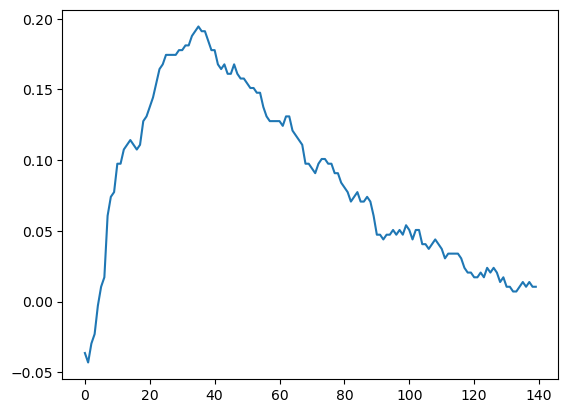

3.22591284445571e-11


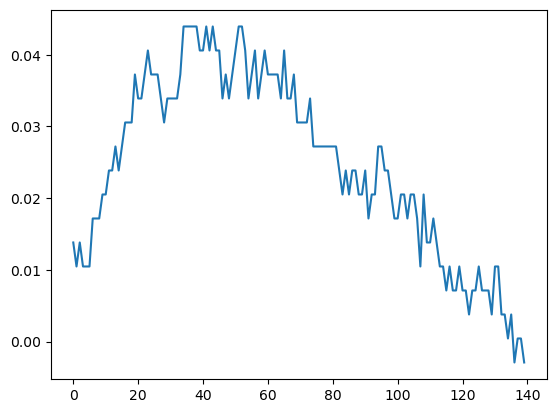

2.041820302668693e-11


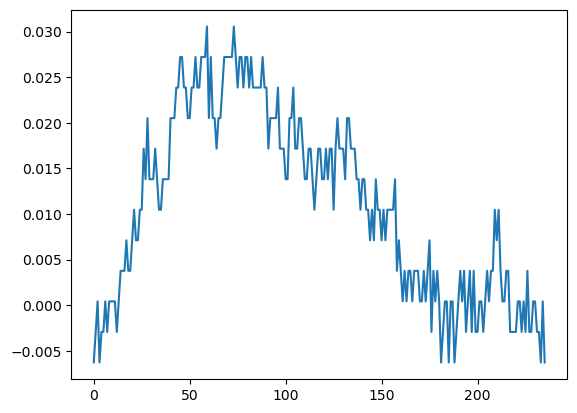

5.5940979994112574e-11


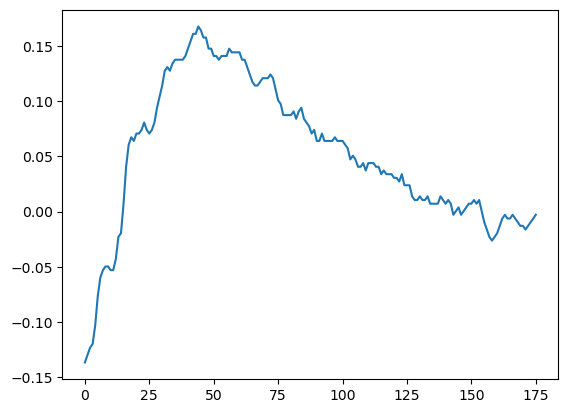

2.8995478806104998e-11


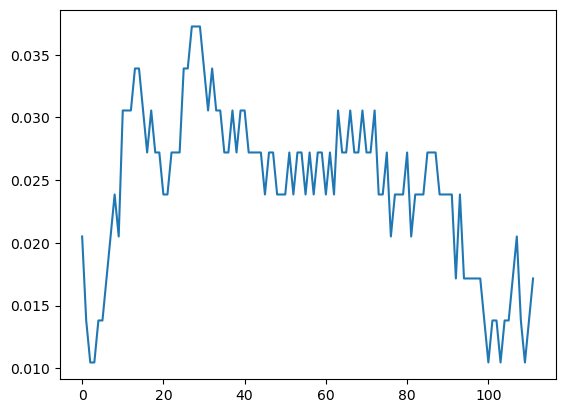

4.5815509751726026e-11


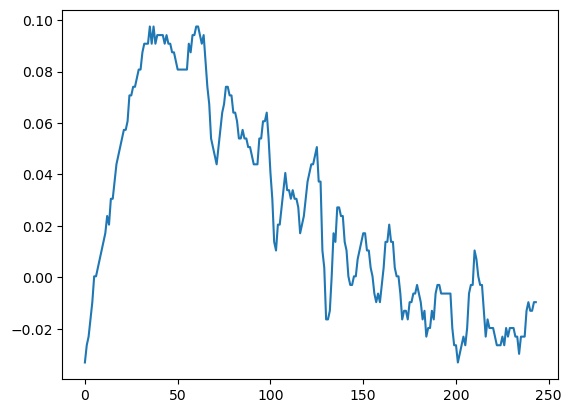

1.3723642154137838e-11


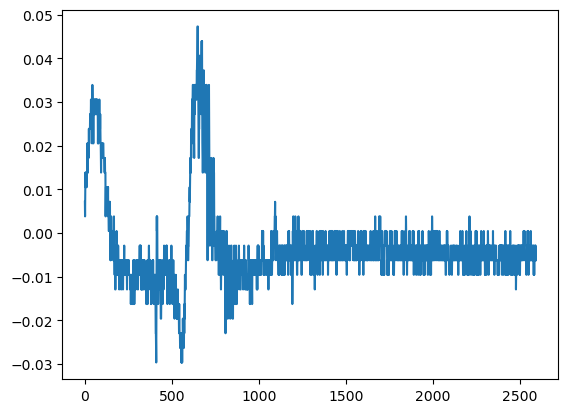

2.6422296354560253e-11


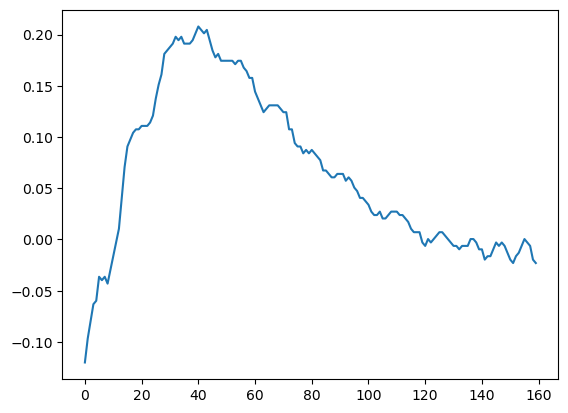

2.4706840451261497e-11


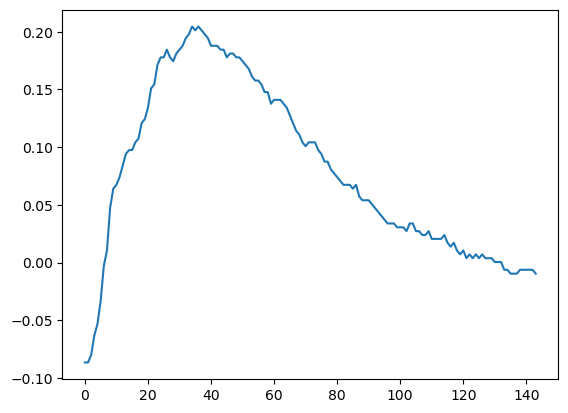

1.2865913941807781e-11


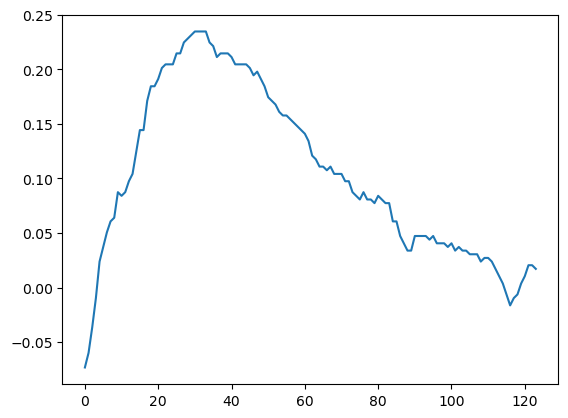

1.2008186465292867e-11


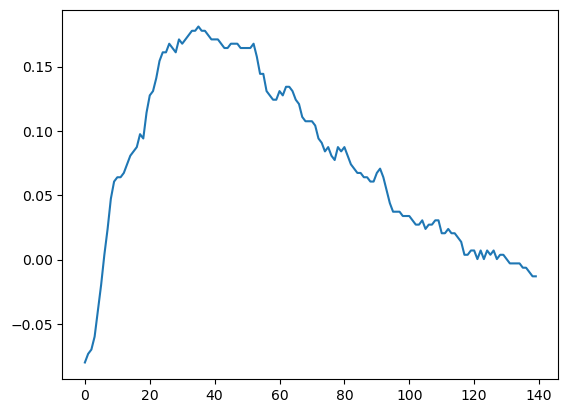

2.3849114492376874e-11


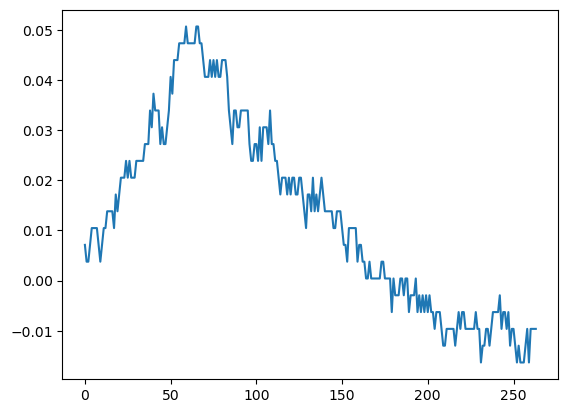

3.1568661261649736e-11


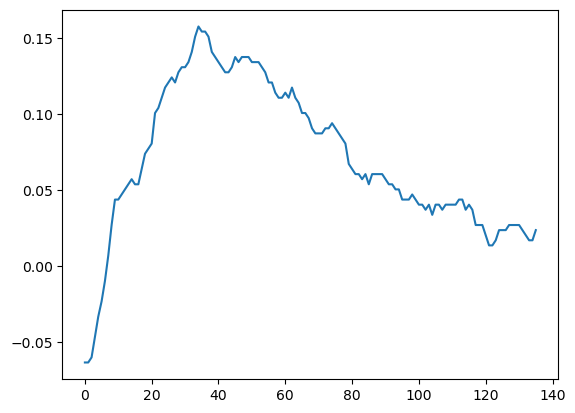

1.956047497881066e-11


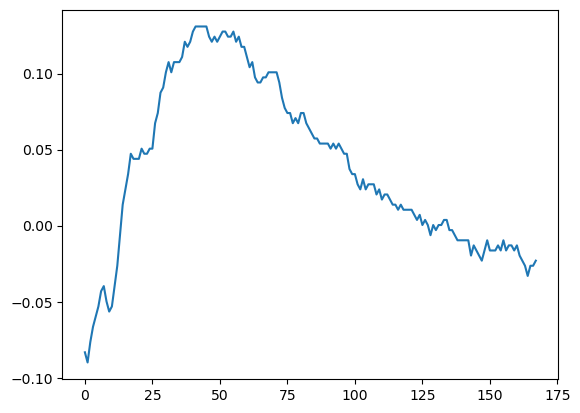

2.7280024793344104e-11


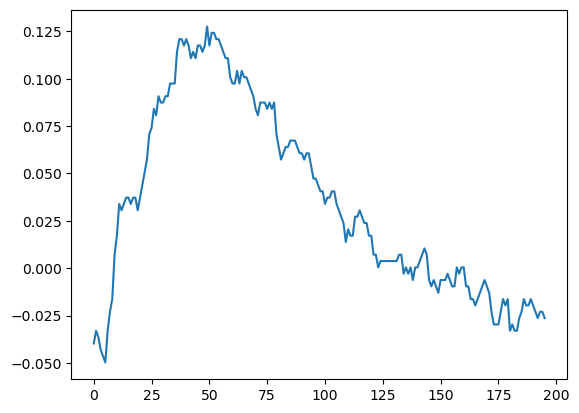

2.127593070565563e-11


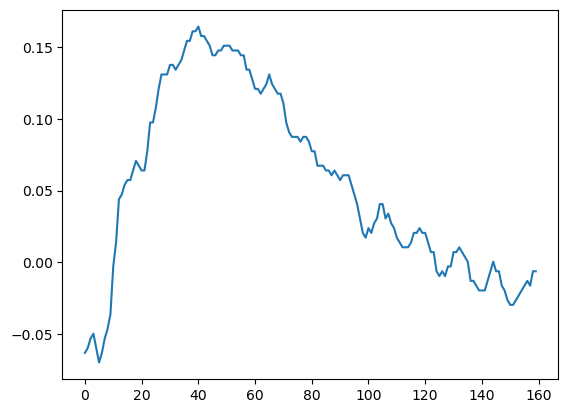

2.556456494879416e-11


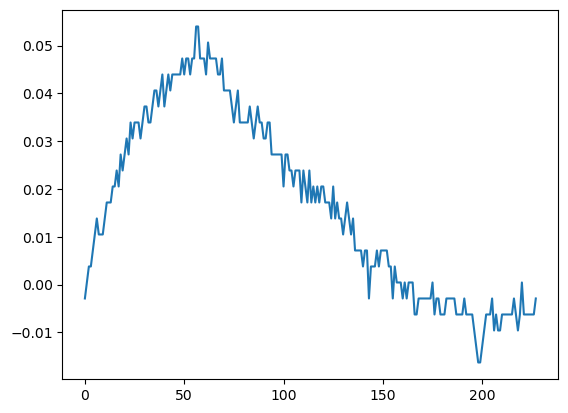

1.3723642378591627e-11


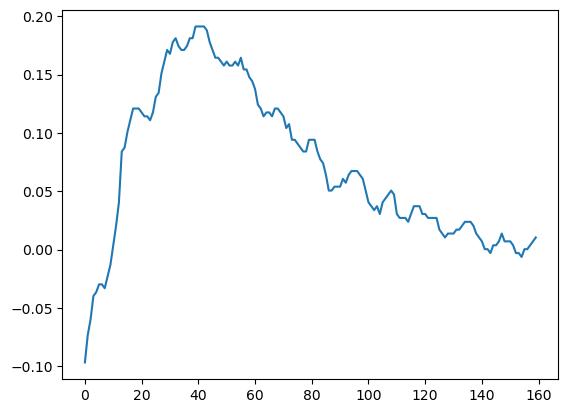

2.3849113351654158e-11


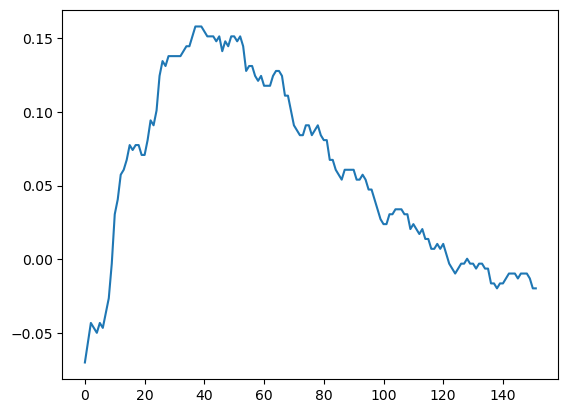

4.083640646228143e-11


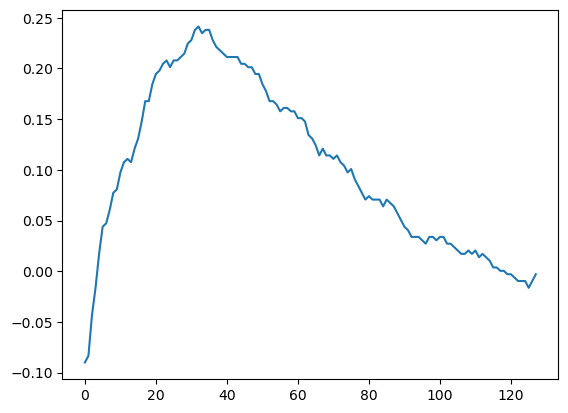

7.719548671810727e-12


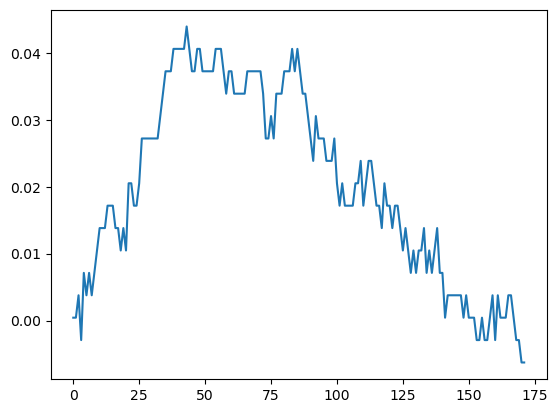

3.8953690394689736e-11


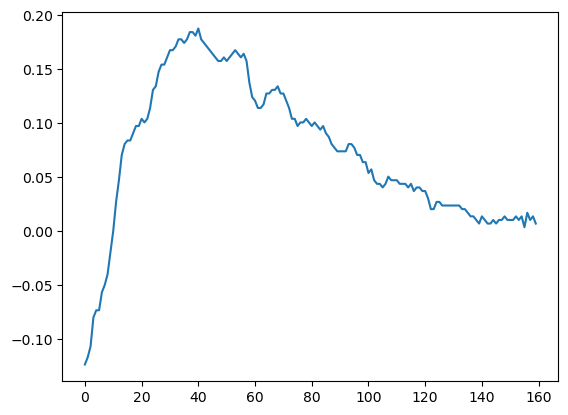

3.569004118228438e-11


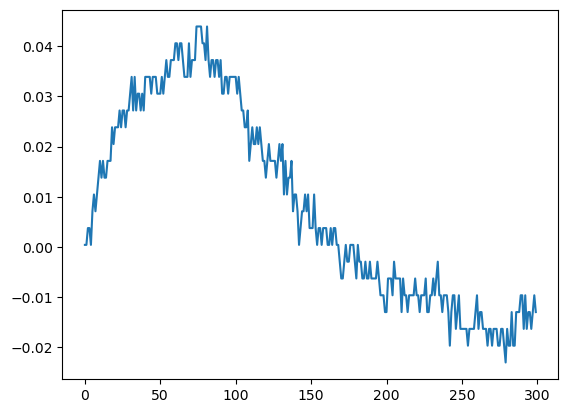

1.629682424277501e-11


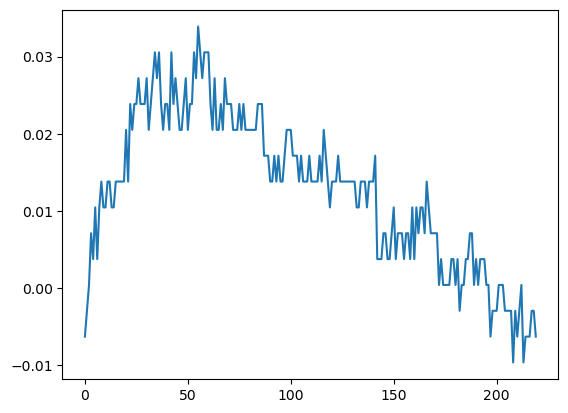

1.887000764258868e-11


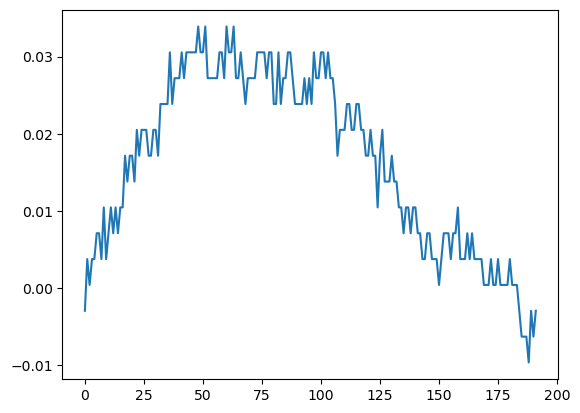

1.2008187030654227e-11


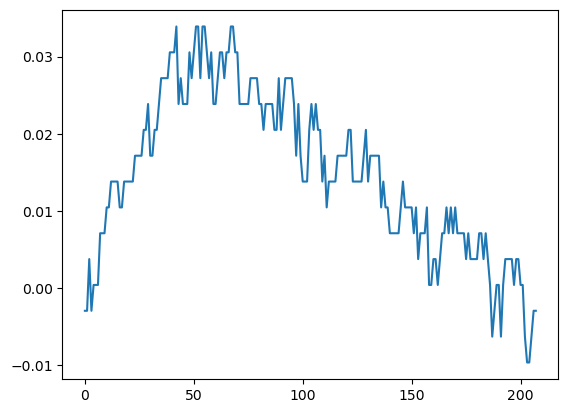

4.3409586802834524e-11


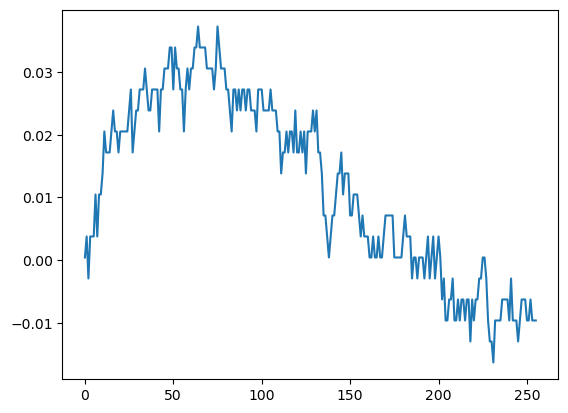

2.487410097646201e-11


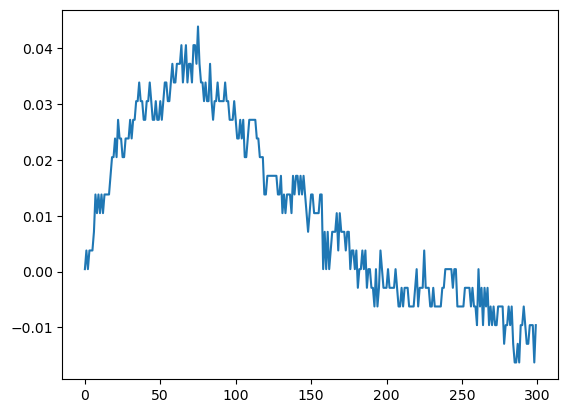

1.5439097716529027e-11


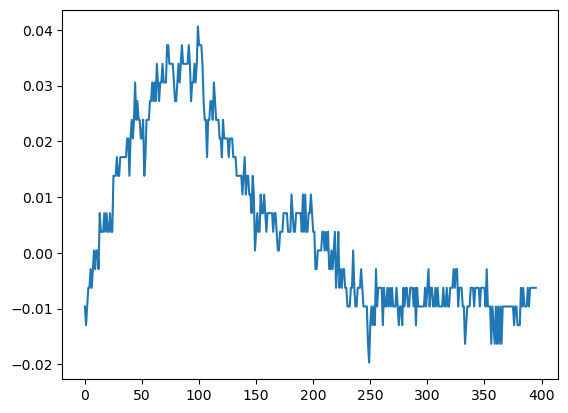

4.8388694406437866e-11


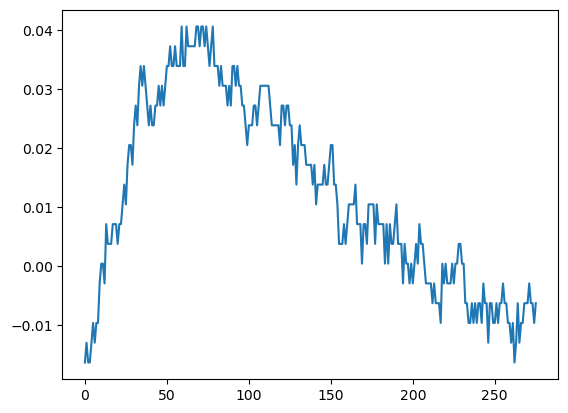

2.401637328549331e-11


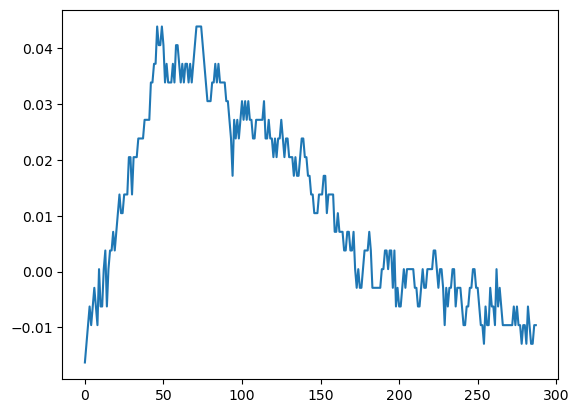

3.585729587969584e-11


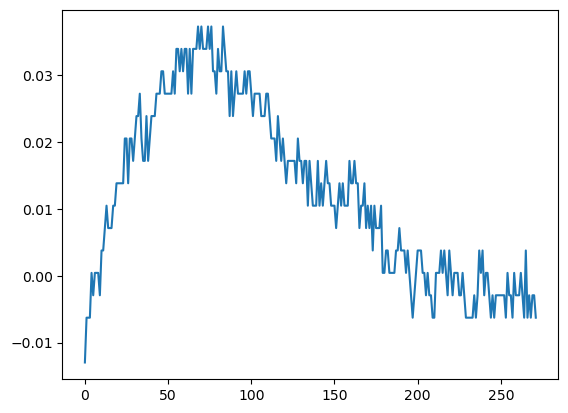

2.384911258783901e-11


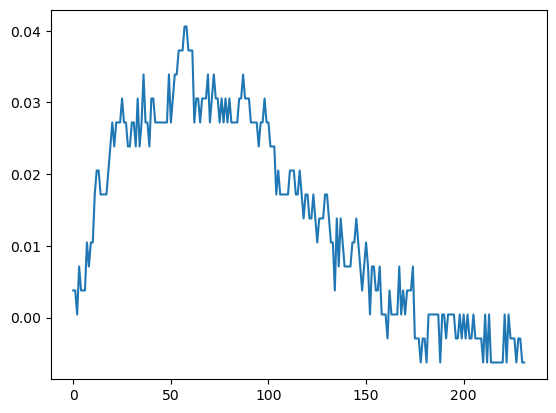

7.207054750762363e-11


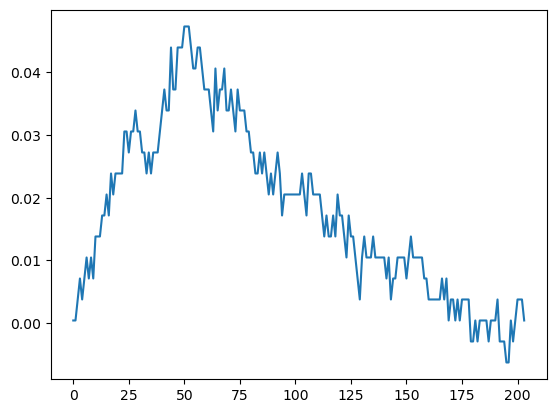

2.8137751700497656e-11


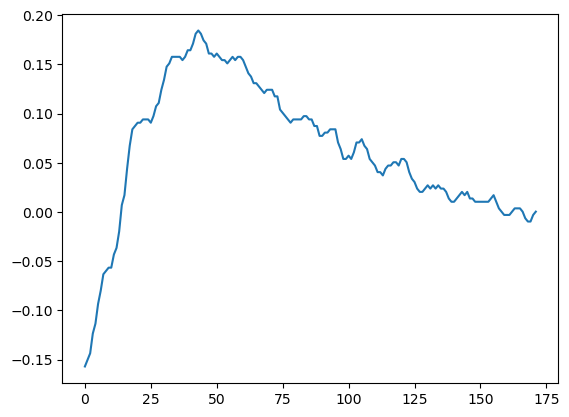

2.1443191058402356e-11


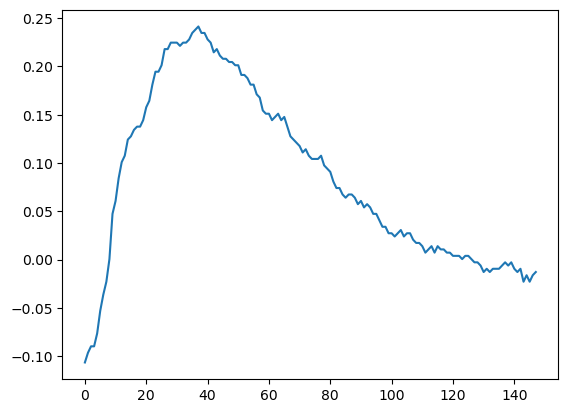

2.4706838041640613e-11


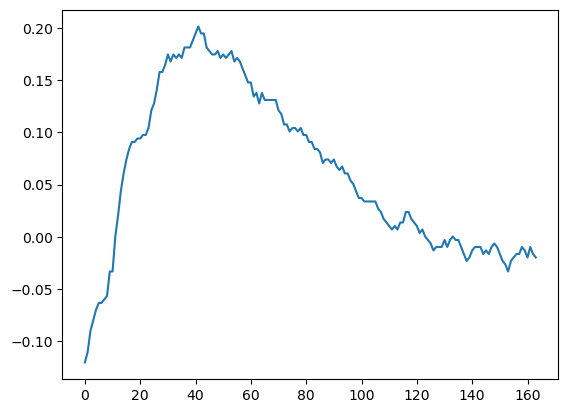

3.2426390071341156e-11


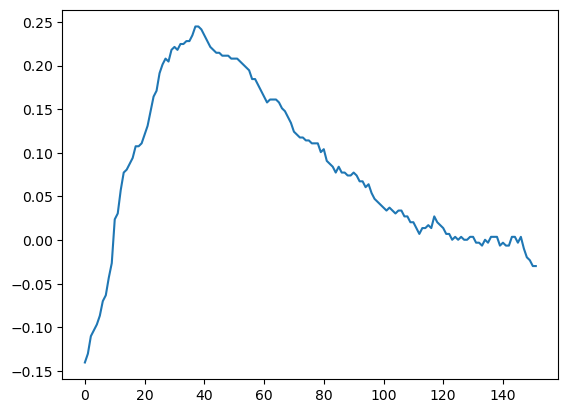

2.728002326371381e-11


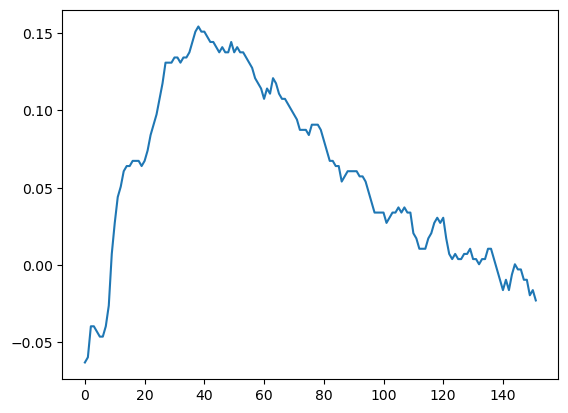

1.7154551921743707e-11


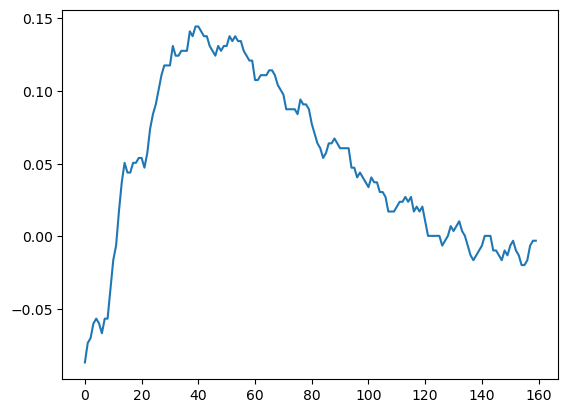

1.4581369668652752e-11


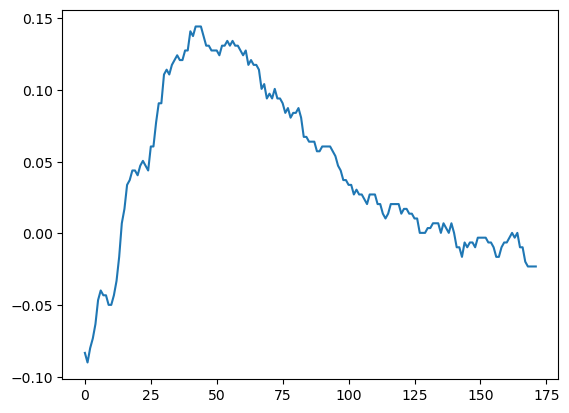

2.3158645610524607e-11


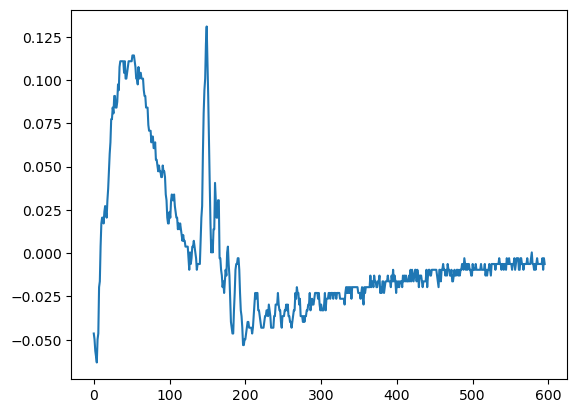

2.315864600543218e-11


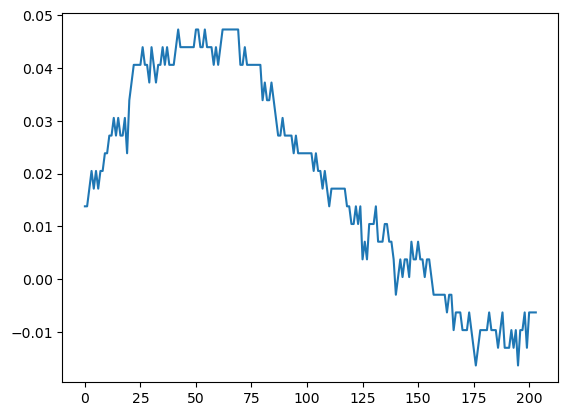

3.05436762851949e-11


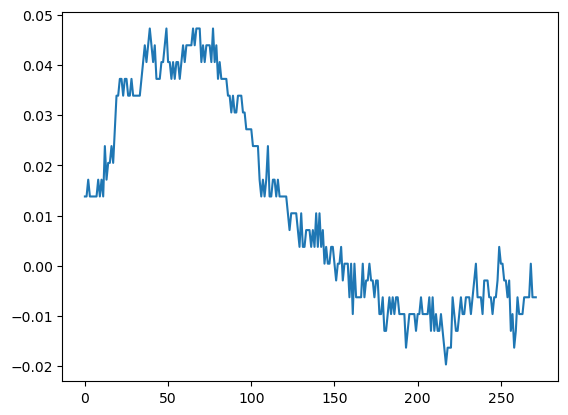

2.6255033048831293e-11


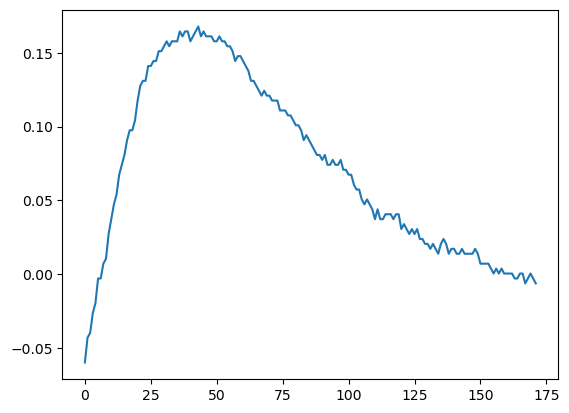

1.629682463568258e-11


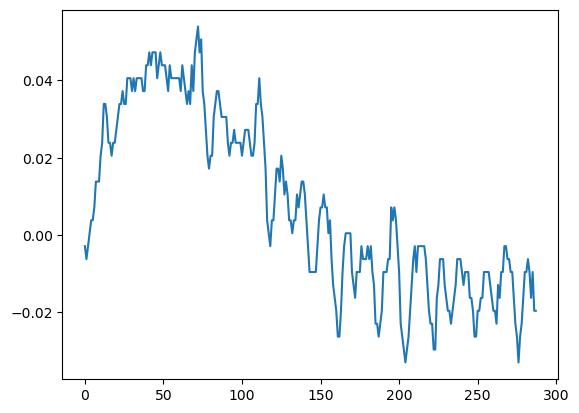

1.3723642374591627e-11


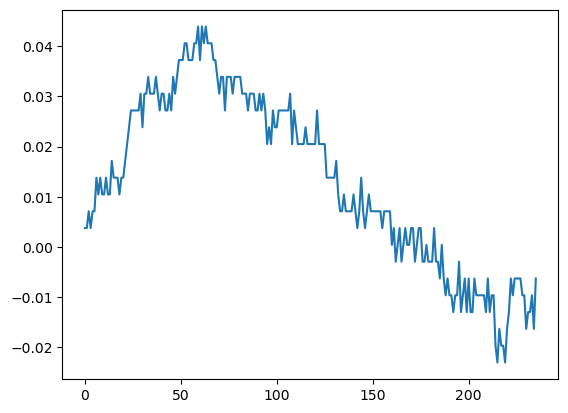

2.230091642992562e-11


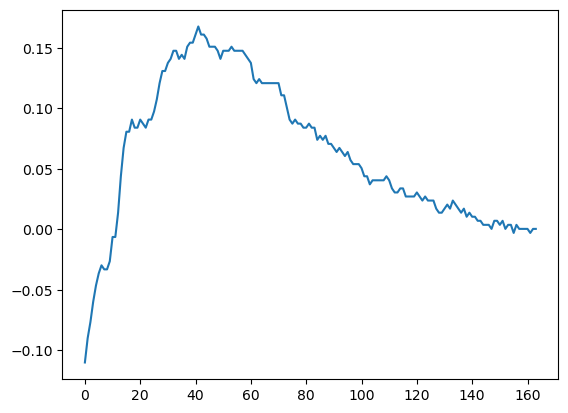

1.3723641999684054e-11


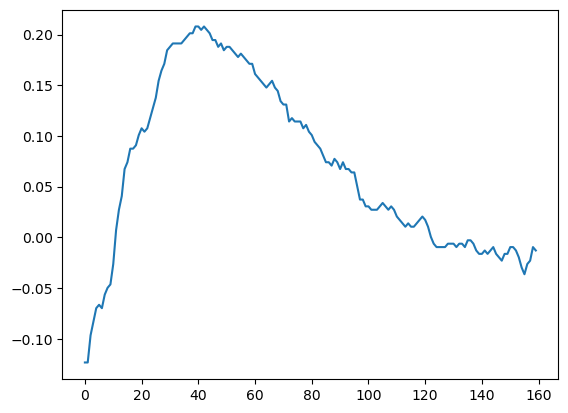

3.397458249245716e-11


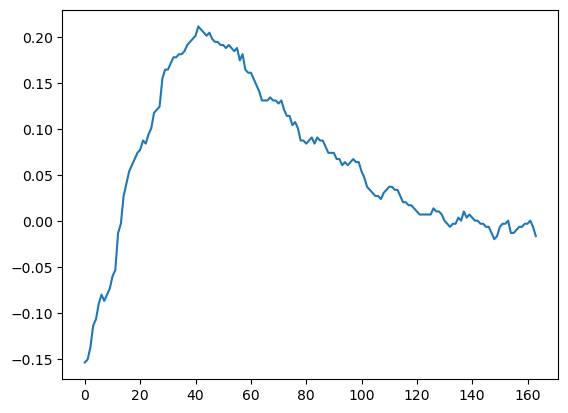

7.190328716487692e-11


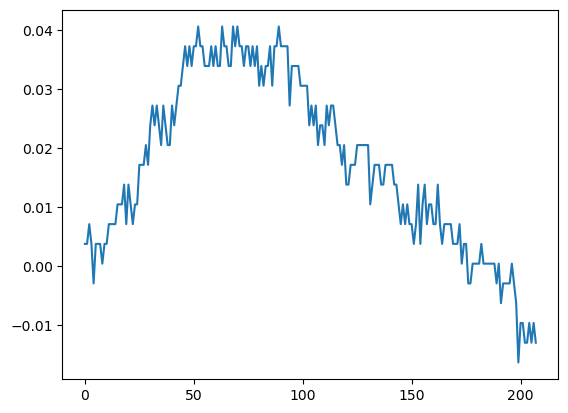

1.9727734938649808e-11


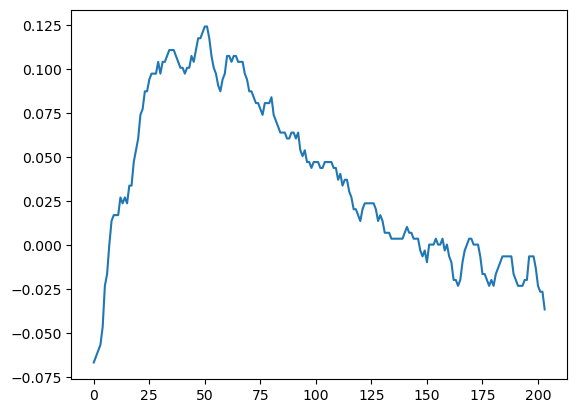

3.071093434449618e-11


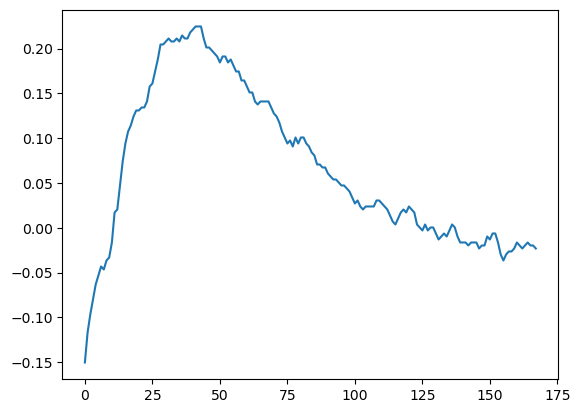

2.0418200067704685e-11


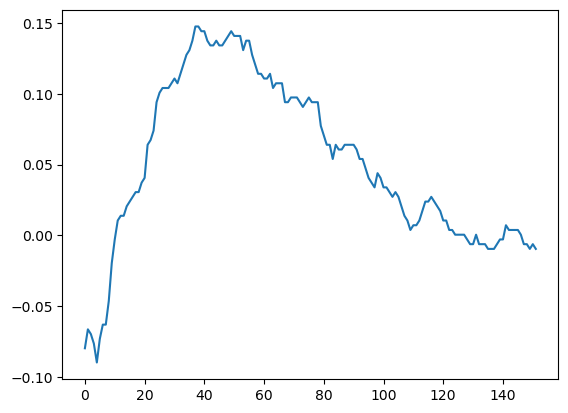

2.0418202266871787e-11


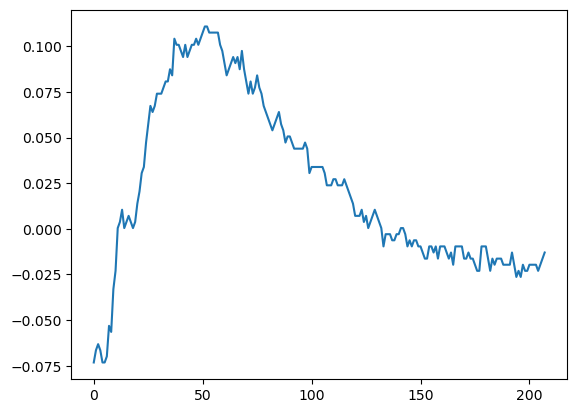

4.083640608337386e-11


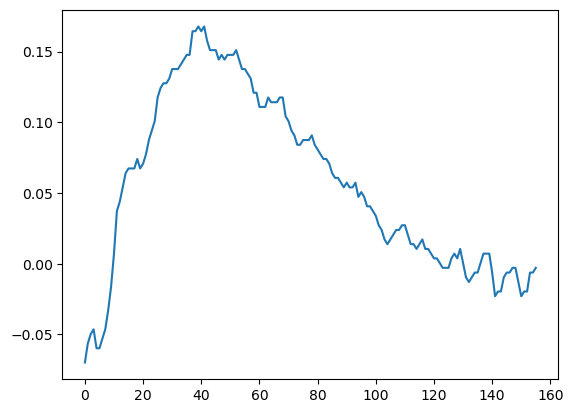

2.5564566472424457e-11


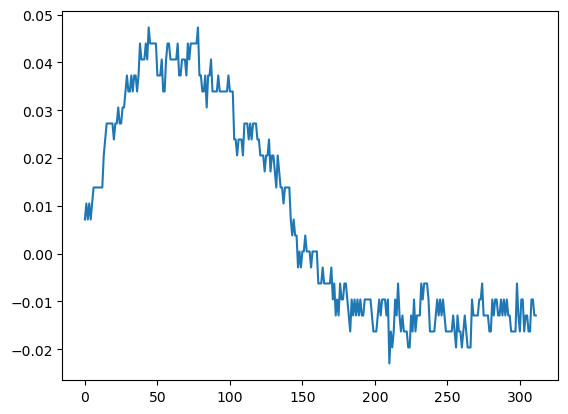

5.267733209174455e-11


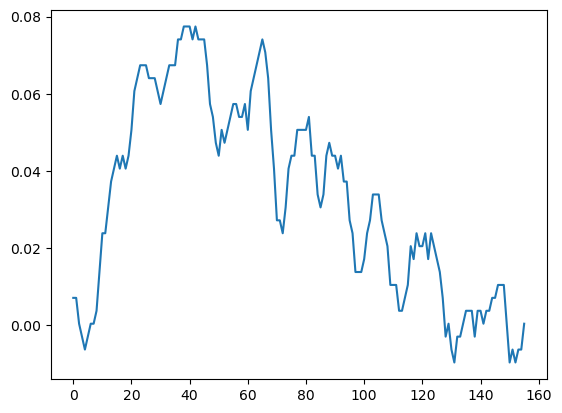

1.8012278830897262e-11


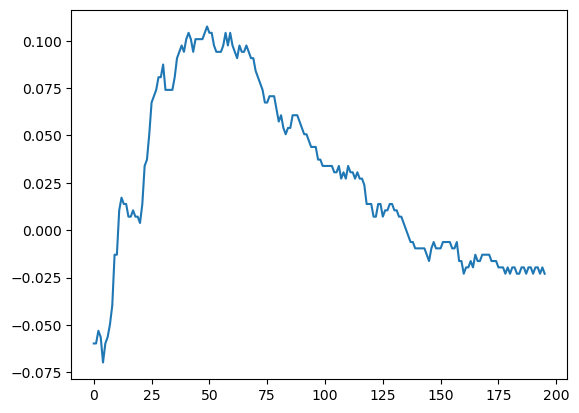

2.2133658765531905e-11


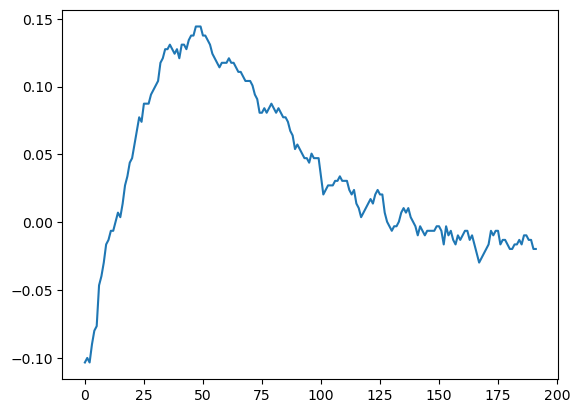

2.4706841774438003e-11


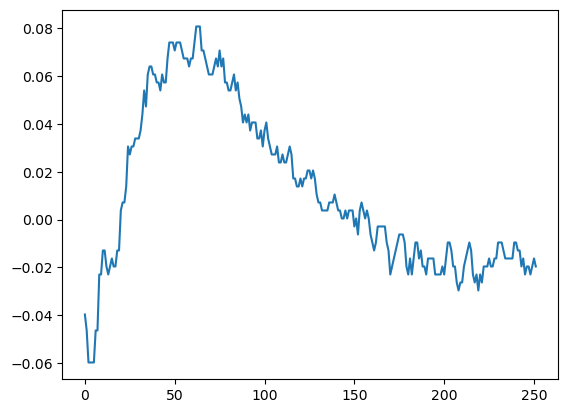

5.336780049441092e-11


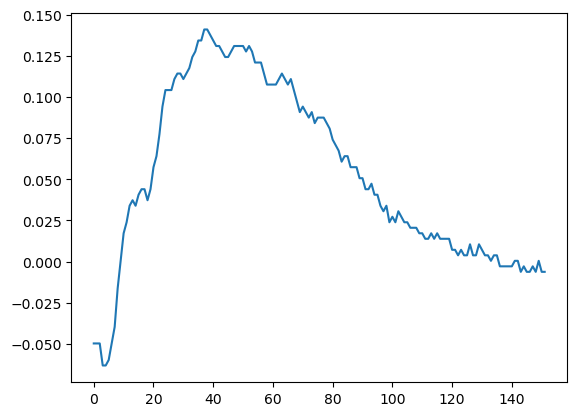

1.78450203966884e-11


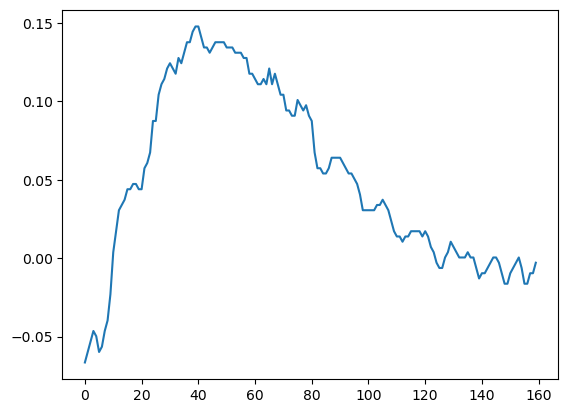

2.573182636198527e-11


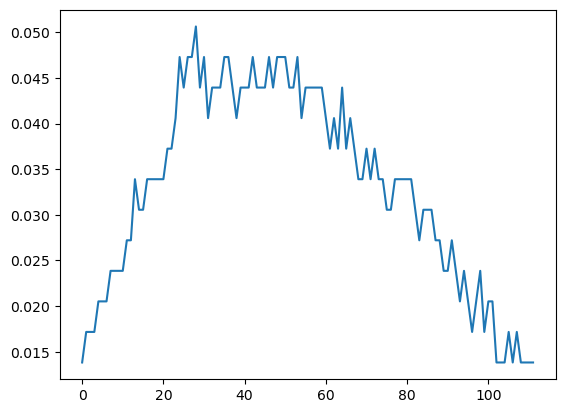

1.2008185885931508e-11


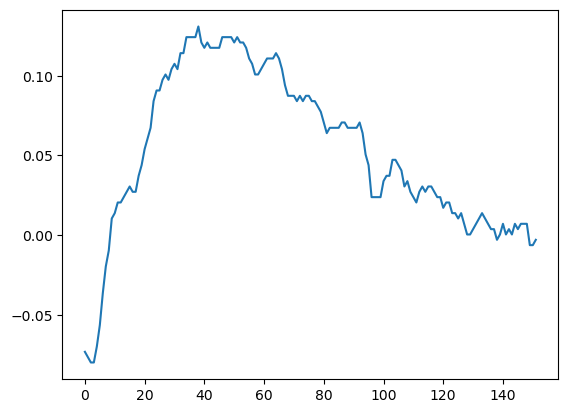

1.3723641993684054e-11


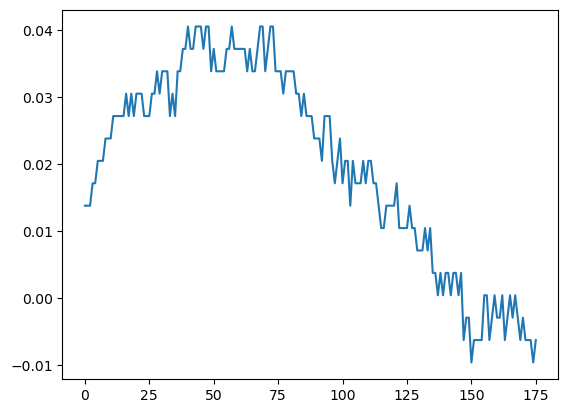

In [19]:
for i in range(n_segs):
    plt.plot(waveforms[i, int(trig_pos[i]):int(peak_pos[i]+3*(peak_pos[i]-trig_pos[i])), 2])
    print(areas[i])
    
    plt.show()

(array([2., 1., 1., 3., 1., 0., 4., 4., 6., 6., 2., 1., 4., 2., 2., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 2., 0., 2., 0., 2., 2., 3., 3., 1., 1., 1., 0.,
        3., 3., 1., 0., 0., 2., 1., 0., 3., 2., 2., 3., 1., 2., 1., 2., 1.,
        1., 1., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 1., 1.]),
 array([5.40033207e-09, 5.63323606e-09, 5.86614005e-09, 6.09904403e-09,
        6.33194802e-09, 6.56485201e-09, 6.79775599e-09, 7.03065998e-09,
        7.26356397e-09, 7.49646796e-09, 7.72937194e-09, 7.96227593e-09,
        8.19517992e-09, 8.42808390e-09, 8.66098789e-09, 8.89389188e-09,
        9.12679587e-09, 9.35969985e-09, 9.59260384e-09, 9.82550783e-09,
        1.00584118e-08, 1.02913158e-08, 1.05242198e-08, 1.07571238e-08,
        1.09900278e-08, 1.12229317e-08, 1.14558357e-08, 1.16887397e-08,
        1.19216437e-08, 1.21545477e-08, 1.2387

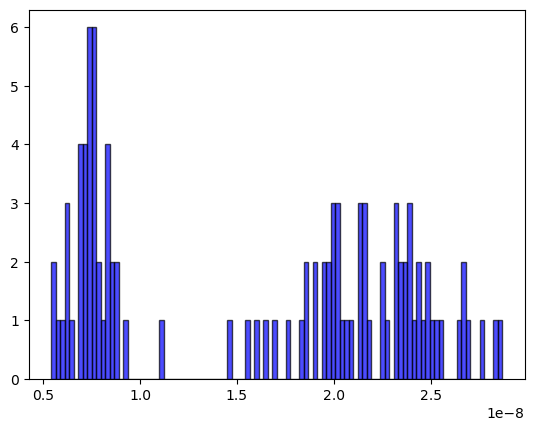

In [7]:
plt.hist(areas, bins=100, color='blue', edgecolor='black', alpha=0.7)

In [8]:
def integrate(filename, seg_len):

    filepath = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/MPhys Sem 1 SiPM-Scintillation (KeySight Oscilloscope)/"
    data = np.genfromtxt(filepath + filename, delimiter=',', skip_header=3)
    n_segs = len(data) // seg_len

    waveforms = np.zeros((n_segs, seg_len, 3))
    for i in range(n_segs):
        waveforms[i] = data[i*seg_len:(i+1)*seg_len]
    
    trig_pos = np.zeros(n_segs)
    for i in range(n_segs):
        trig_pos[i] = np.argmin(waveforms[i, :, 1])

    areas = np.zeros(n_segs)

    area = np.zeros(500)
    for i in range(n_segs):
        for j in range(500):
            pos = int(trig_pos[i]-250+j)
            area[j] = (waveforms[i,pos+1,0]-waveforms[i, pos, 0])*np.sum(waveforms[i, pos:pos+1, 2])/2
            if area[j] < 0: area[j] = 0
        areas[i] = np.sum(area)

    return areas

c:\Users\louis\anaconda3\envs\vuv\lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\louis\anaconda3\envs\vuv\lib\site-packages\matplotlib\axes\_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

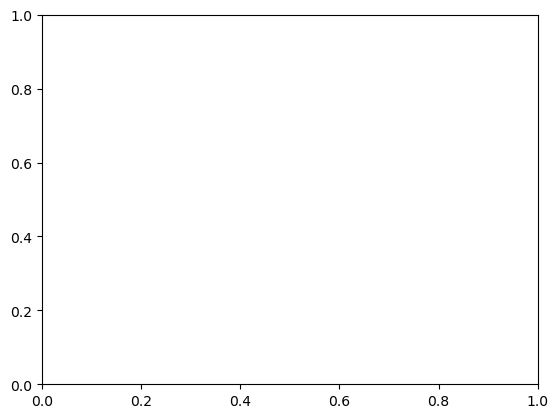

In [9]:
areas_55V_1000V_air = integrate("55V_1000V_air.csv", 12500)
plt.hist(areas_55V_1000V_air, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title("55V 1000V Air")
plt.xlabel("[Vs]")
plt.ylabel("Entries")

Text(0, 0.5, 'Entries')

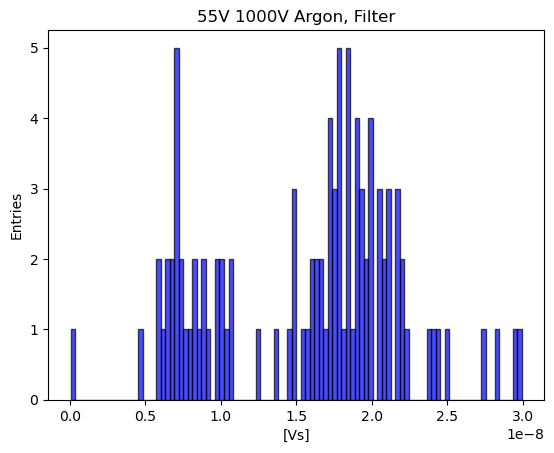

In [ ]:
areas_55V_1000V_Ar_filter = integrate("55V_1000V_Ar_filter.csv", 12500)
plt.hist(areas_55V_1000V_Ar_filter, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title("55V 1000V Argon, Filter")
plt.xlabel("[Vs]")
plt.ylabel("Entries")

In [ ]:
#areas_55V_1100V_air = integrate("55V_1100V_air.csv", 12500)


IndexError: index 12500 is out of bounds for axis 1 with size 12500

(0.0, 6.0)

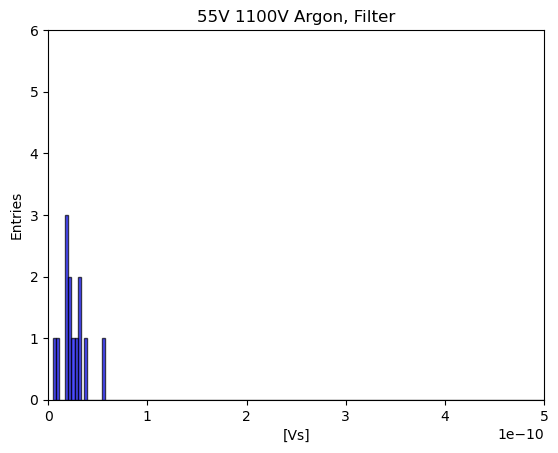

In [14]:
areas_55V_1100V_Ar_filter = integrate("55V_1100V_Ar_filter.csv", 12500)
plt.hist(areas_55V_1100V_Ar_filter, bins=10000, color='blue', edgecolor='black', alpha=0.7)
plt.title("55V 1100V Argon, Filter")
plt.xlabel("[Vs]")
plt.ylabel("Entries")
plt.xlim(0e-8,0.5e-9)
plt.ylim(0,6)


In [ ]:
#areas_55V_1200V_air_blind = integrate("55V_1200V_air_blind.csv", 12500)


IndexError: index 12500 is out of bounds for axis 1 with size 12500

In [ ]:
#areas_55V_1200V_air_filter = integrate("55V_1200V_air_filter.csv", 12750)


IndexError: index 12750 is out of bounds for axis 1 with size 12750

In [ ]:
#areas_55V_1200V_air_iris = integrate("55V_1200V_air_iris.csv", 12500)


IndexError: index 12500 is out of bounds for axis 1 with size 12500

ValueError: autodetected range of [nan, nan] is not finite

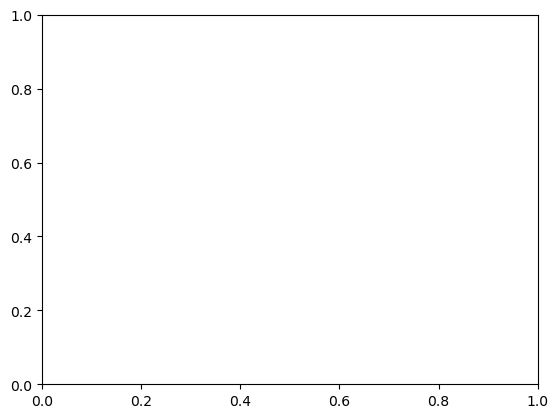

In [ ]:
areas_55V_1200V_air = integrate("55V_1200V_air.csv", 3571)
plt.hist(areas_55V_1200V_air, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title("55V 1200V Air")
plt.xlabel("[Vs]")
plt.ylabel("Entries")


Text(0, 0.5, 'Entries')

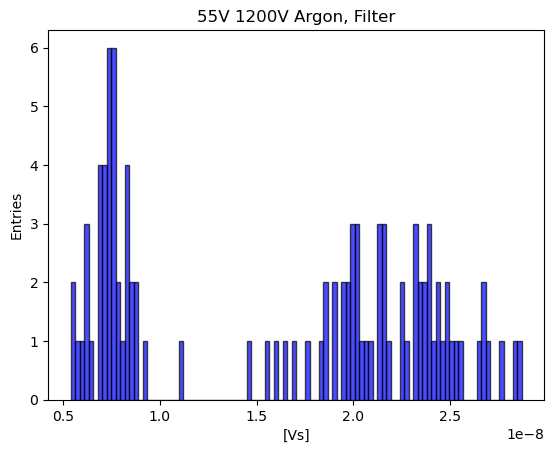

In [ ]:
areas_55V_1200V_Ar_filter = integrate("55V_1200V_Ar_filter.csv", 12500)
plt.hist(areas_55V_1200V_Ar_filter, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title("55V 1200V Argon, Filter")
plt.xlabel("[Vs]")
plt.ylabel("Entries")